# Installation

In [1]:
%cd /content
!git clone https://github.com/CristianMaza/Normalizing-Flow-PV-Model
%cd /content/Normalizing-Flow-PV-Model
!pip install -r requirements.txt

/content
Cloning into 'Normalizing-Flow-PV-Model'...
remote: Enumerating objects: 106, done.
remote: Counting objects: 100% (106/106), done.
remote: Compressing objects: 100% (99/99), done.
remote: Total 106 (delta 5), reused 106 (delta 5), pack-reused 0
Receiving objects: 100% (106/106), 16.51 MiB | 25.69 MiB/s, done.
Resolving deltas: 100% (5/5), done.
/content/Normalizing-Flow-PV-Model
  Cloning https://github.com/AWehenkel/Normalizing-Flows/ to /tmp/pip-req-build-xehs7pmf
  Running command git clone --filter=blob:none --quiet https://github.com/AWehenkel/Normalizing-Flows/ /tmp/pip-req-build-xehs7pmf
  Resolved https://github.com/AWehenkel/Normalizing-Flows/ to commit fe535e25cda32781296557ac5a523a6d2ade1761
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 12.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 189.5/189.5 kB 16.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.8/224.8 kB 23.4 MB/s eta 0:00

# Execute main.py
Train and Evaluate all at once in one script

In [2]:
#!python main.py

# Execute step by step

### Load data

In [3]:
import torch
from GEFcom2014 import load_data
import os
from models import *
import numpy as np

samples_per_day = 24
dataset_dir = 'df_power.csv'

data = load_data(path_name=dataset_dir, test_size=50, random_state=0, samples_per_day=samples_per_day)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print('Using gpu: %s ' % torch.cuda.is_available())
gpu = True  # put False to use CPU
print('Using gpu: %s ' % torch.cuda.is_available())
if gpu:
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

dir_path = 'export/multi_nfs/'
if not os.path.isdir(dir_path):  # test if directory exist
    os.makedirs(dir_path)

28416
1184
Indices where PV is always 0: [ 0  1  2  3  4  5 21 22 23]
#LS 1084 days #VS 50 days # TEST 50 days
Using gpu: True 
Using gpu: True 


### Built the LS, VS, and TEST sets

In [4]:
ylim_loss = [-50, 50]
ymax_plf = 2
ylim_crps = [0, 10]
nb_zones = 1
indices = data[6]

df_x_LS = data[0].copy()
df_y_LS = data[1].copy()
df_x_VS = data[2].copy()
df_y_VS = data[3].copy()
df_x_TEST = data[4].copy()
df_y_TEST = data[5].copy()

nb_days_LS = len(df_y_LS)
nb_days_VS = len(df_y_VS)
nb_days_TEST = len(df_y_TEST)
print('#LS %s days #VS %s days # TEST %s days' % (nb_days_LS/nb_zones, nb_days_VS/nb_zones, nb_days_TEST/nb_zones))


#LS 1084.0 days #VS 50.0 days # TEST 50.0 days


###  Scale the LS, VS, and TEST sets

In [5]:
from GEFcom2014.models import scale_data_multi, plot_loss

# WARNING: use the scaler fitted on the TRAIN LS SET !!!!
x_LS_scaled, y_LS_scaled, x_VS_scaled, y_VS_scaled, x_TEST_scaled, y_TEST_scaled, y_LS_scaler = scale_data_multi(x_LS=df_x_LS.values, y_LS=df_y_LS.values, x_VS=df_x_VS.values, y_VS=df_y_VS.values, x_TEST=df_x_TEST.values, y_TEST=df_y_TEST.values)

non_null_indexes = list(np.delete(np.asarray([i for i in range(24)]), indices))

# Rebuilt the PV observations with the removed time periods
df_y_TEST.columns = non_null_indexes
for i in indices:
    df_y_TEST[i] = 0
df_y_TEST = df_y_TEST.sort_index(axis=1)

df_y_VS.columns = non_null_indexes
for i in indices:
    df_y_VS[i] = 0
df_y_VS = df_y_VS.sort_index(axis=1)


### Set the model(s)

In [6]:
n_s = 100
N_q = 99

# Set the torch seed for result reproducibility
torch_seed = 0
torch.manual_seed(torch_seed)

# Define the NFs hyper-parameters
nb_epoch = 500
cf_UMNN_M = {
    'name': 'UMNN_M_1',
    'nb_steps': 1,
    'nb_layers': 4,
    'nb_neurons': 300,
    'out_size': 20,
    'weight_decay': 5e-4,
#    'learning_rate': 5e-4,
    'learning_rate': 1e-4,
    'conditioner_type': 'AutoregressiveConditioner',
    'normalizer_type': 'MonotonicNormalizer',
}

cf_AN_M = {
    'name': 'AN_M_1',
    # 'nb_steps': 4,
    # 'nb_layers': 4,
    # 'nb_neurons': 500,
    'nb_steps': 5,
    'nb_layers': 5,
    'nb_neurons': 300,
    'out_size': 2,
#    'weight_decay': 1e-2,
    'weight_decay': 1e-3,
    'learning_rate': 1e-4,
    'conditioner_type': 'AutoregressiveConditioner',
    'normalizer_type': 'AffineNormalizer',
}


print('UMNN-M nb_steps %s nb_layers %s nb_neurons %s out_size %s weight_decay %.4e lr %.4e' % (cf_UMNN_M['nb_steps'], cf_UMNN_M['nb_layers'], cf_UMNN_M['nb_neurons'], cf_UMNN_M['out_size'], cf_UMNN_M['weight_decay'], cf_UMNN_M['learning_rate']))
print('AN-M   nb_steps %s nb_layers %s nb_neurons %s out_size %s weight_decay %.4e lr %.4e' % (cf_AN_M['nb_steps'], cf_AN_M['nb_layers'], cf_AN_M['nb_neurons'], cf_AN_M['out_size'], cf_AN_M['weight_decay'], cf_AN_M['learning_rate']))

UMNN-M nb_steps 1 nb_layers 4 nb_neurons 300 out_size 20 weight_decay 5.0000e-04 lr 1.0000e-04
AN-M   nb_steps 5 nb_layers 5 nb_neurons 300 out_size 2 weight_decay 1.0000e-03 lr 1.0000e-04


### Build the NF (Select model type)

In [7]:
import json
from numpyencoder import NumpyEncoder

# Select the model

config = cf_UMNN_M
#config = cf_AN_M

name = config['name'] + '_' + str(torch_seed)
print(name)

if config['normalizer_type'] == 'AffineNormalizer':
    config['conditioner_args'] = {"in_size": y_LS_scaled.shape[1],
                                  "hidden": [config['nb_neurons']] * config['nb_layers'], "out_size": 2,
                                  "cond_in": x_LS_scaled.shape[1]}
    normalizer_type = AffineNormalizer
    config['normalizer_args'] = {}

elif config['normalizer_type'] == 'MonotonicNormalizer':
    config['conditioner_args'] = {"in_size": y_LS_scaled.shape[1],
                                  "hidden": [config['nb_neurons']] * config['nb_layers'],
                                  "out_size": config['out_size'], "cond_in": x_LS_scaled.shape[1]}
    normalizer_type = MonotonicNormalizer
    config['normalizer_args'] = {
        'integrand_net': [config['out_size'] * 2, config['out_size'] * 2, config['out_size'] * 2],
        'cond_size': config['out_size'], 'nb_steps': 50, 'solver': "CCParallel", 'hot_encoding': True}

config['Adam_args'] = {"lr": config['learning_rate'], "weight_decay": config['weight_decay']}

with open(dir_path + config['name'] + '.json', 'w') as file:
    json.dump(config, file, cls=NumpyEncoder)

nfs = buildFCNormalizingFlow(nb_steps=config['nb_steps'], conditioner_type=AutoregressiveConditioner,
                              conditioner_args=config['conditioner_args'], normalizer_type=normalizer_type,
                              normalizer_args=config['normalizer_args'])
opt = torch.optim.Adam(nfs.parameters(), lr=config['learning_rate'], weight_decay=config['weight_decay'])

UMNN_M_1_0


### Train (fit) the NF

Fit NFs with 500 epochs
Fitting time_tot 1 min
Training time 77.19 s
epoch 124 ll VS is min = -0.41 ll TEST = 14.71


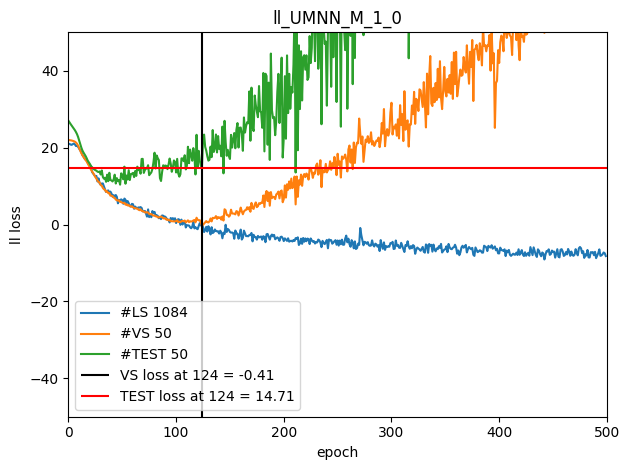

In [8]:
from GEFcom2014.models.NFs import fit_NF
from torch.utils.benchmark import timer
from GEFcom2014.utils import dump_file

print('Fit NFs with %s epochs' % (nb_epoch))
training_time = 0.
start = timer()
loss, best_flow, last_flow = fit_NF(nb_epoch=nb_epoch, x_LS=x_LS_scaled, y_LS=y_LS_scaled, x_VS=x_VS_scaled,
                                    y_VS=y_VS_scaled, x_TEST=x_TEST_scaled, y_TEST=y_TEST_scaled,
                                    flow=nfs,
                                    opt=opt, gpu=gpu)

end = timer()
training_time += end - start
print('Training time %.2f s' % (training_time))
epoch_min = np.nanargmin(loss[:, 1])
print('epoch %s ll VS is min = %.2f ll TEST = %.2f' % (epoch_min, loss[epoch_min, 1], loss[epoch_min, 2]))

dump_file(dir=dir_path, name='loss_' + name, file=loss)
dump_file(dir=dir_path, name='model_' + name + '_best', file=best_flow)
dump_file(dir=dir_path, name='model_' + name + '_last', file=last_flow)

plot_loss(loss=loss, nb_days=[nb_days_LS, nb_days_VS, nb_days_TEST], ylim=ylim_loss, dir_path=dir_path, name='ll_' + name)

### Build scenarios on VS & TEST

In [9]:
from GEFcom2014.models.NFs import build_nfs_scenarios

# load flow model from file:
# best_flow = read_file(dir=dir_path, name=name)

max_power = 1

# Scenarios are generated into a dict of length nb days (#VS or # TEST sizes)
# Each day of the dict is an array of shape (n_scenarios, 24)

generation_time = 0.
start = timer()
s_TEST = build_nfs_scenarios(n_s=n_s, x=x_TEST_scaled,
                              y_scaler=y_LS_scaler, flow=best_flow,
                              conditioner_args=config['conditioner_args'], max=max_power, gpu=gpu, non_null_indexes=non_null_indexes, samples_per_day=samples_per_day)
s_VS = build_nfs_scenarios(n_s=n_s, x=x_VS_scaled,
                            y_scaler=y_LS_scaler, flow=best_flow,
                            conditioner_args=config['conditioner_args'], max=max_power, gpu=gpu, non_null_indexes=non_null_indexes, samples_per_day=samples_per_day)
end = timer()
generation_time += end - start
print('Generation time (LS, VS, TEST) %.2f s' % (generation_time))
# Export the NF scenarios
# dict of nb_days with an array per day of shape = (nb_scenarios, 24)
dump_file(dir=dir_path, name='scenarios_' + name + '_' + str(n_s) + '_TEST', file=s_TEST)
dump_file(dir=dir_path, name='scenarios_' + name + '_' + str(n_s) + '_VS', file=s_VS)

3 6
Scenario generation time_tot 0.2 min
3 6
Scenario generation time_tot 0.2 min
Generation time (LS, VS, TEST) 22.88 s


### Evaluate

PLF TEST 1.5174 VS 1.4424



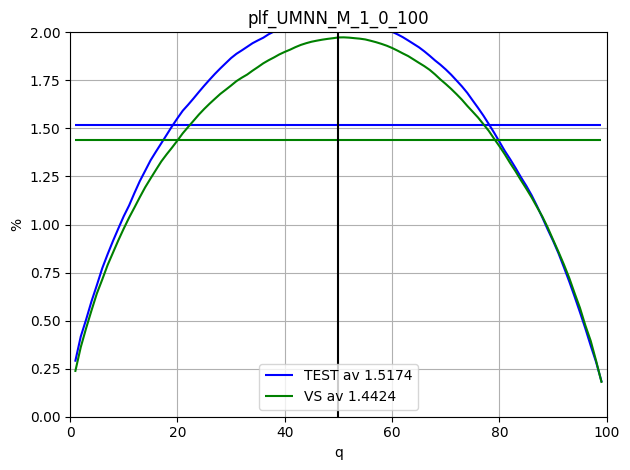

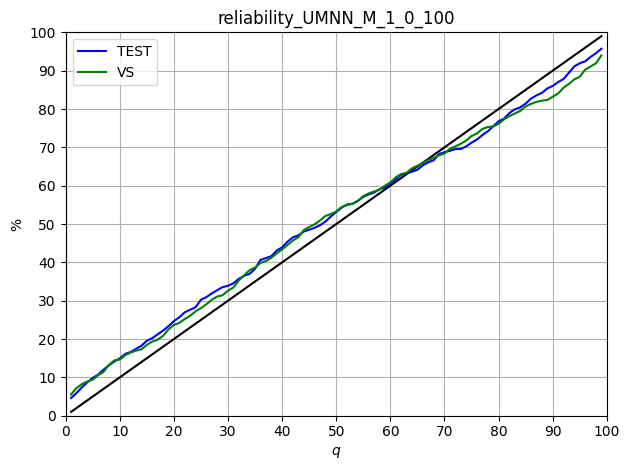

MAE TEST 3.39 VS 3.47
RMSE TEST 3.63 VS 3.83



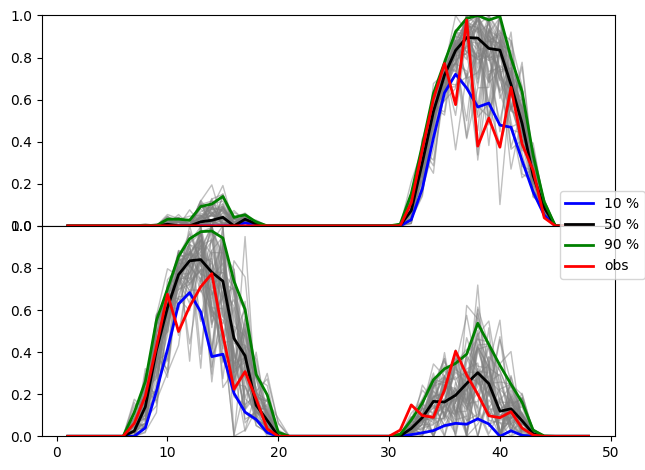

CRPS TEST 3.00 VS 2.85



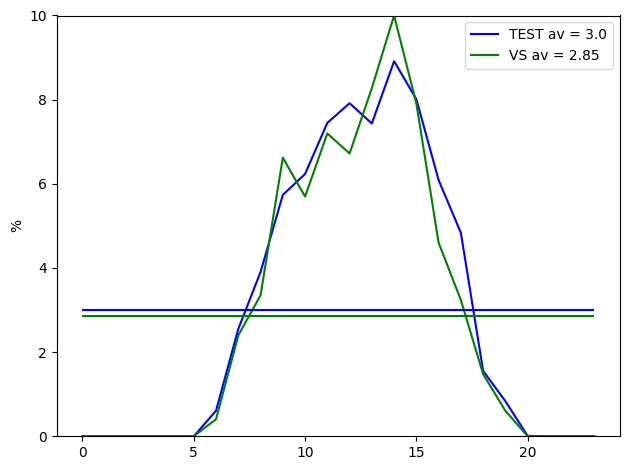

In [10]:
from GEFcom2014.forecast_quality import quantiles_and_evaluation

quantiles_and_evaluation(dir_path=dir_path, s_VS=s_VS, s_TEST=s_TEST, N_q=N_q, df_y_VS=df_y_VS, df_y_TEST=df_y_TEST,
                         name=name, ymax_plf=ymax_plf, ylim_crps=ylim_crps, nb_zones=nb_zones)